<a href="https://colab.research.google.com/github/Tasfia-007/The-Wiser-Project/blob/main/the_wiser_noise_model_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#using a noise model from real hardware

In [ ]:


# Step 1: Run this cell first to install all necessary packages.
# After this finishes, you MUST restart the runtime.
# Go to the menu: Runtime -> Restart session
!pip install -q qiskit qiskit-aer matplotlib pylatexenc
!pip install qiskit-ibm-runtime
print("✅ All packages installed successfully. Please restart the runtime now.")



✅ All packages installed successfully. Please restart the runtime now.


#Load IBM Quantum Account

In [ ]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Kraus, SuperOp
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime.fake_provider import FakeVigoV2


# Import from Qiskit Aer noise module
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)

In [ ]:
from qiskit_ibm_runtime.fake_provider import FakeVigoV2
device_backend = FakeVigoV2()

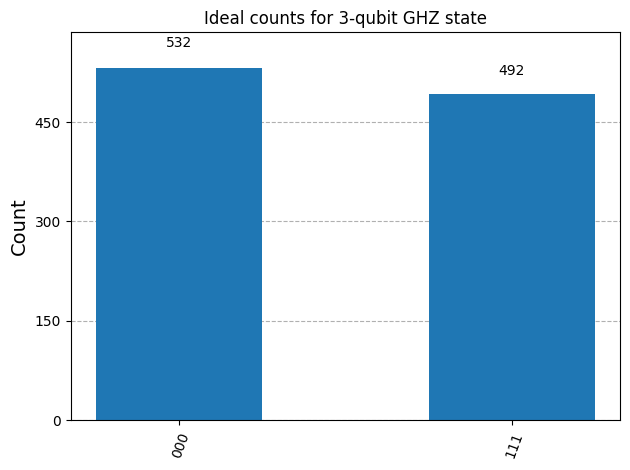

In [ ]:
# Construct quantum circuit
circ = QuantumCircuit(3, 3)
circ.h(0)
circ.cx(0, 1)
circ.cx(1, 2)
circ.measure([0, 1, 2], [0, 1, 2])

sim_ideal = AerSimulator()

# Execute and get counts
result = sim_ideal.run(transpile(circ, sim_ideal)).result()
counts = result.get_counts(0)
plot_histogram(counts, title='Ideal counts for 3-qubit GHZ state')

In [ ]:
sim_vigo = AerSimulator.from_backend(device_backend)

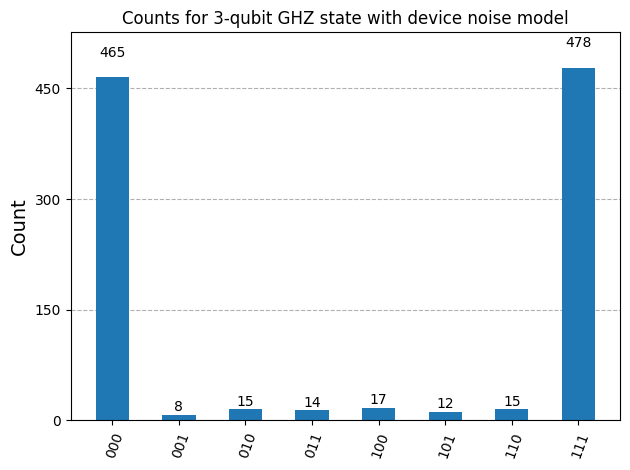

In [ ]:
# Transpile the circuit for the noisy basis gates
tcirc = transpile(circ, sim_vigo)

# Execute noisy simulation and get counts
result_noise = sim_vigo.run(tcirc).result()
counts_noise = result_noise.get_counts(0)
plot_histogram(counts_noise,
               title="Counts for 3-qubit GHZ state with device noise model")

In [ ]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit_aer.primitives import Sampler
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime.fake_provider import FakeManhattanV2, FakeTorino,FakeMarrakesh
from qiskit_aer.noise import NoiseModel
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from collections import defaultdict
import os

try:
    from IPython.display import display
    IS_IPYTHON = True
except ImportError:
    IS_IPYTHON = False

def create_n_layer_qgb(n_layers: int, target_distribution="exponential_custom"):
    """
    Generates a Qiskit QuantumCircuit for an N-layer Quantum Galton Board with a left-skewed exponential distribution.
    """
    num_working_qubits = 2 * n_layers + 1
    num_qubits = num_working_qubits + 1
    num_clbits = n_layers + 1

    qc = QuantumCircuit(num_qubits, num_clbits, name=f"{n_layers}-Layer QGB")

    control_qubit = 0

    # --- Step 1: Initialization ---
    initial_ball_pos = n_layers + 1
    qc.x(initial_ball_pos)
    qc.barrier()

    # --- Step 2: Build the Layers ---
    for layer in range(n_layers):
        qc.reset(control_qubit)

        base_bias = np.pi/3
        decay_factor = 0.8
        bias_angle = base_bias * (decay_factor ** layer)
        qc.ry(bias_angle, control_qubit)

        peg_positions = range(n_layers + 1 - layer, n_layers + 1 + layer + 1, 2)

        for i, peg_pos in enumerate(peg_positions):
            left_channel = peg_pos - 1
            right_channel = peg_pos + 1

            qc.cswap(control_qubit, left_channel, peg_pos)
            qc.cx(peg_pos, control_qubit)
            qc.cswap(control_qubit, peg_pos, right_channel)

            if i < len(peg_positions) - 1:
                qc.cx(right_channel, control_qubit)

        qc.barrier()

    # --- Step 3: Measurement ---
    output_qubits = range(1, num_working_qubits + 2, 2)
    qc.measure(output_qubits, range(num_clbits))

    return qc

def get_available_devices():
    """
    List available fake backend devices
    """
    devices = {
        'manhattan': FakeManhattanV2,
        'torino': FakeTorino,
        'marrakesh':FakeMarrakesh
    }
    return devices

def run_noisy_simulation(circuit, shots=8192, device_name='marrakesh'):
    """
    Run the circuit with device noise model simulation
    """
    # Get available devices
    devices = get_available_devices()

    # Create fake device backend
    if device_name.lower() in devices:
        fake_device = devices[device_name.lower()]()
    else:
        print(f"Unknown device '{device_name}'. Available devices: {list(devices.keys())}")
        print("Using default: FakeManhattan")
        fake_device = FakeManhattan()

    print(f"Using device: {fake_device.name}")
    print(f"Circuit requires {circuit.num_qubits} qubits, device has {fake_device.num_qubits} qubits")

    # Check if circuit fits on device
    if circuit.num_qubits > fake_device.num_qubits:
        print(f"WARNING: Circuit needs {circuit.num_qubits} qubits but device only has {fake_device.num_qubits}")
        print("Falling back to noise-model-only simulation (no coupling map constraints)")

        # Create noise model from the fake device
        noise_model = NoiseModel.from_backend(fake_device)

        # Create AerSimulator with noise model
        sim_noisy = AerSimulator(noise_model=noise_model)

        # Transpile with basic optimization only
        transpiled_circuit = transpile(circuit, sim_noisy, optimization_level=0)

    else:
        # Create noise model from the fake device
        noise_model = NoiseModel.from_backend(fake_device)

        # Get device properties
        coupling_map = fake_device.coupling_map
        basis_gates = fake_device.basis_gates

        # Create AerSimulator with noise model
        sim_noisy = AerSimulator(
            noise_model=noise_model,
            coupling_map=coupling_map,
            basis_gates=basis_gates
        )

        # Transpile circuit for the noisy backend with higher optimization
        try:
            transpiled_circuit = transpile(circuit, sim_noisy, optimization_level=3)
        except Exception as e:
            print(f"High optimization failed: {e}")
            print("Trying with coupling map disabled...")
            sim_noisy = AerSimulator(noise_model=noise_model)
            transpiled_circuit = transpile(circuit, sim_noisy, optimization_level=1)

    print(f"Original circuit depth: {circuit.depth()}")
    print(f"Transpiled circuit depth: {transpiled_circuit.depth()}")
    print(f"Number of qubits on device: {fake_device.num_qubits}")

    # Run the noisy simulation
    job = sim_noisy.run(transpiled_circuit, shots=shots)
    result = job.result()
    counts = result.get_counts(0)

    return counts, noise_model, transpiled_circuit

def compare_ideal_vs_noisy(circuit, n_layers, shots=8192, device_name='marrakesh'):
    """
    Compare ideal simulation vs noisy simulation results
    """
    print("=== IDEAL SIMULATION ===")

    # Use the original Sampler (V1) for compatibility
    sampler = Sampler()
    job = sampler.run(circuit, shots=shots)
    result = job.result()

    # Get counts from the result
    counts_data = result.quasi_dists[0]

    # Convert quasi-distribution to counts and then to probabilities
    ideal_distribution = defaultdict(float, {i: 0.0 for i in range(n_layers + 1)})

    for outcome, probability in counts_data.items():
        # Convert integer outcome to binary string
        bitstring = format(outcome, f'0{n_layers + 1}b')
        try:
            position = bitstring.index('1')
            ideal_distribution[position] += probability
        except ValueError:
            pass

    print("Ideal Results (Probabilities):")
    print({k: v for k, v in sorted(ideal_distribution.items())})

    print("\n=== NOISY SIMULATION ===")
    # Run noisy simulation
    noisy_counts, noise_model, transpiled_circuit = run_noisy_simulation(circuit, shots, device_name)

    # Convert counts to probabilities
    total_shots = sum(noisy_counts.values())
    noisy_distribution = defaultdict(float, {i: 0.0 for i in range(n_layers + 1)})

    for bitstring, count in noisy_counts.items():
        prob = count / total_shots
        try:
            position = bitstring.index('1')
            noisy_distribution[position] += prob
        except ValueError:
            pass

    print("Noisy Results (Probabilities):")
    print({k: v for k, v in sorted(noisy_distribution.items())})

    # Plot comparison
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Ideal histogram
    positions = list(ideal_distribution.keys())
    probabilities = list(ideal_distribution.values())
    ax1.bar(positions, probabilities, alpha=0.7, color='blue')
    ax1.set_title(f'Ideal {n_layers}-Layer QGB Distribution')
    ax1.set_xlabel('Position')
    ax1.set_ylabel('Probability')
    ax1.grid(True, alpha=0.3)

    # Noisy histogram
    positions_noisy = list(noisy_distribution.keys())
    probabilities_noisy = list(noisy_distribution.values())
    ax2.bar(positions_noisy, probabilities_noisy, alpha=0.7, color='red')
    ax2.set_title(f'Noisy {n_layers}-Layer QGB Distribution')
    ax2.set_xlabel('Position')
    ax2.set_ylabel('Probability')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()

    if IS_IPYTHON:
        display(fig)
    else:
        plt.show()

    return ideal_distribution, noisy_distribution, noise_model

# --- Example Usage ---
if __name__ == '__main__':
    N_LAYERS = 5

    qgb_circuit = create_n_layer_qgb(N_LAYERS)

    print(f"\n--- Circuit Information for {N_LAYERS}-Layer QGB ---")
    print(f"Circuit depth: {qgb_circuit.depth()}")
    print(f"Number of qubits: {qgb_circuit.num_qubits}")
    print(f"Number of classical bits: {qgb_circuit.num_clbits}")

    # Print available devices
    devices = get_available_devices()
    print(f"\nAvailable devices: {list(devices.keys())}")

    print("\nCircuit diagram:")
    print(qgb_circuit.draw(fold=120))

    print(f"\n--- Comparing Ideal vs Noisy Simulation for {N_LAYERS}-Layer QGB ---")

    # Test device name
    TEST_DEVICE = 'marrakesh'

    # Compare ideal and noisy results
    ideal_dist, noisy_dist, noise_model = compare_ideal_vs_noisy(qgb_circuit, N_LAYERS, shots=8192, device_name=TEST_DEVICE)

    # --- Noise Model Information ---
    print(f"\n--- Noise Model Information ---")
    print(f"Device used: {TEST_DEVICE}")
    print(f"Noise model type: {type(noise_model)}")
    print(f"Number of noise instructions: {len(noise_model._noise_instructions) if hasattr(noise_model, '_noise_instructions') else 'N/A'}")

    # Calculate and display the difference between ideal and noisy
    print(f"\n--- Difference Analysis ---")
    total_variation_distance = 0
    for position in range(N_LAYERS + 1):
        ideal_prob = ideal_dist.get(position, 0.0)
        noisy_prob = noisy_dist.get(position, 0.0)
        difference = abs(ideal_prob - noisy_prob)
        total_variation_distance += difference
        print(f"Position {position}: Ideal={ideal_prob:.4f}, Noisy={noisy_prob:.4f}, Diff={difference:.4f}")

    print(f"\nTotal Variation Distance: {total_variation_distance/2:.4f}")

    plt.close('all')


--- Circuit Information for 6-Layer QGB ---
Circuit depth: 92
Number of qubits: 14
Number of classical bits: 7

Available devices: ['manhattan', 'torino', 'marrakesh']

Circuit diagram:
            ░      ┌─────────┐   ┌───┐    ░      ┌───────────┐   ┌───┐   ┌───┐   ┌───┐    ░      ┌─────────────┐   »
 q_0: ──────░──|0>─┤ Ry(π/3) ├─■─┤ X ├─■──░──|0>─┤ Ry(4π/15) ├─■─┤ X ├─■─┤ X ├─■─┤ X ├─■──░──|0>─┤ Ry(0.67021) ├─■─»
            ░      └─────────┘ │ └─┬─┘ │  ░      └───────────┘ │ └─┬─┘ │ └─┬─┘ │ └─┬─┘ │  ░      └─────────────┘ │ »
 q_1: ──────░──────────────────┼───┼───┼──░────────────────────┼───┼───┼───┼───┼───┼───┼──░──────────────────────┼─»
            ░                  │   │   │  ░                    │   │   │   │   │   │   │  ░                      │ »
 q_2: ──────░──────────────────┼───┼───┼──░────────────────────┼───┼───┼───┼───┼───┼───┼──░──────────────────────┼─»
            ░                  │   │   │  ░                    │   │   │   │   │   │   │  ░                    

/tmp/ipython-input-3990457594.py:245: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  ideal_dist, noisy_dist, noise_model = compare_ideal_vs_noisy(qgb_circuit, N_LAYERS, shots=8192, device_name=TEST_DEVICE)


Ideal Results (Probabilities):
{0: 0.47412109375, 1: 0.400146484375, 2: 0.1102294921875, 3: 0.014892578125, 4: 0.0006103515625, 5: 0.0, 6: 0.0}

=== NOISY SIMULATION ===
Using device: fake_marrakesh
Circuit requires 14 qubits, device has 156 qubits
High optimization failed: 'A connected component of the DAGCircuit is too large for any of the connected components in the coupling map'
Trying with coupling map disabled...
Original circuit depth: 92
Transpiled circuit depth: 1556
Number of qubits on device: 156



--- Circuit Information for 5-Layer QGB ---
Circuit depth: 65
Number of qubits: 12
Number of classical bits: 6

Available devices: ['manhattan', 'torino']

Circuit diagram:
      ┌───┐ ░    ┌───┐    ░ ┌───┐┌───┐ ░    ┌───┐   ┌───┐   ┌───┐    ░      ┌───┐ ░    ┌───┐   ┌───┐   ┌───┐   ┌───┐   »
 q_0: ┤ H ├─░──■─┤ X ├─■──░─┤ X ├┤ H ├─░──■─┤ X ├─■─┤ X ├─■─┤ X ├─■──░──|0>─┤ H ├─░──■─┤ X ├─■─┤ X ├─■─┤ X ├─■─┤ X ├─■─»
      └───┘ ░  │ └─┬─┘ │  ░ └───┘└───┘ ░  │ └─┬─┘ │ └─┬─┘ │ └─┬─┘ │  ░      └───┘ ░  │ └─┬─┘ │ └─┬─┘ │ └─┬─┘ │ └─┬─┘ │ »
 q_1: ──────░──┼───┼───┼──░────────────░──┼───┼───┼───┼───┼───┼───┼──░────────────░──┼───┼───┼───┼───┼───┼───┼───┼───┼─»
            ░  │   │   │  ░            ░  │   │   │   │   │   │   │  ░            ░  │   │   │   │   │   │   │   │   │ »
 q_2: ──────░──┼───┼───┼──░────────────░──┼───┼───┼───┼───┼───┼───┼──░────────────░──┼───┼───┼───┼───┼───┼───┼───┼───┼─»
            ░  │   │   │  ░            ░  │   │   │   │   │   │   │  ░            ░  │   │   │   │  

/tmp/ipython-input-4087227262.py:263: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  ideal_dist, noisy_dist, noise_model = compare_ideal_vs_noisy(qgb_circuit, N_LAYERS, shots=8192, device_name=TEST_DEVICE)


Ideal Results (Probabilities):
{0: 0.031982421875, 1: 0.1536865234375, 2: 0.313232421875, 3: 0.31005859375, 4: 0.1573486328125, 5: 0.03369140625}

=== NOISY SIMULATION ===
Using device: fake_manhattan
Circuit requires 12 qubits, device has 65 qubits
High optimization failed: 'A connected component of the DAGCircuit is too large for any of the connected components in the coupling map'
Trying with coupling map disabled...
Original circuit depth: 65
Transpiled circuit depth: 494
Number of qubits on device: 65
Noisy Results (Probabilities):
{0: 0.1785888671875, 1: 0.21923828125, 2: 0.2137451171875, 3: 0.1298828125, 4: 0.1304931640625, 5: 0.02490234375}


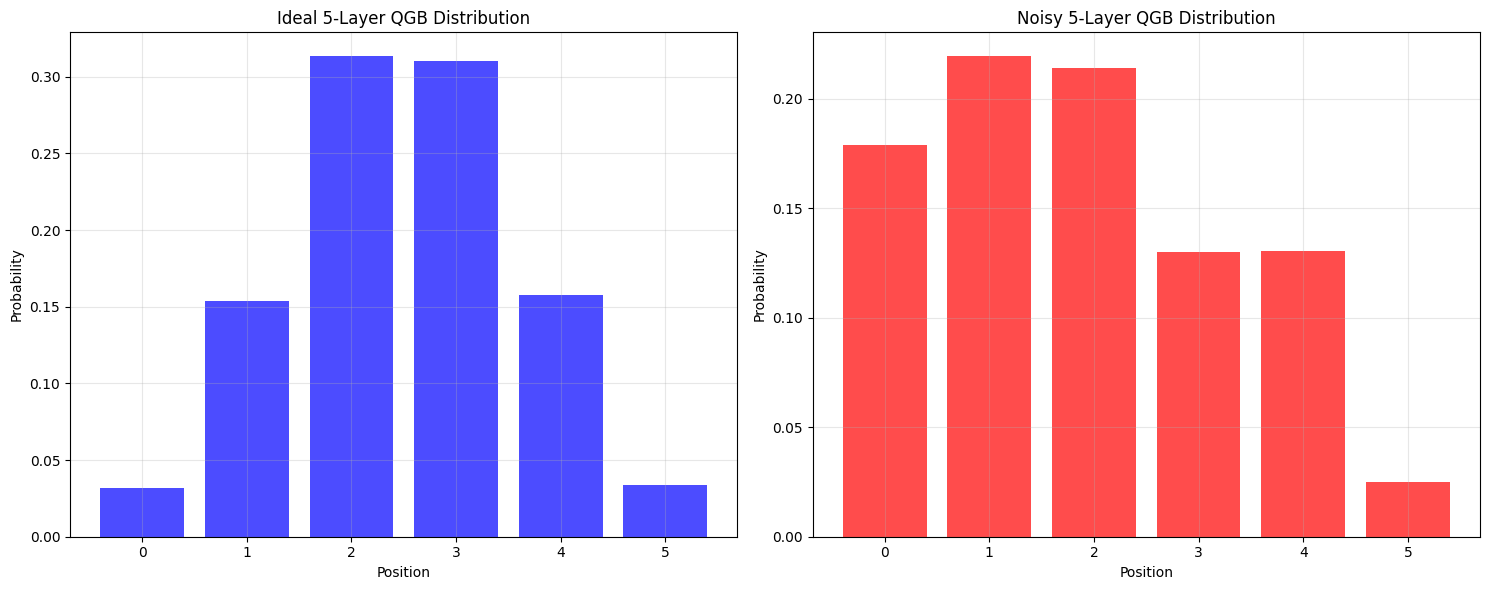


--- Noise Model Information ---
Device used: manhattan
Noise model type: <class 'qiskit_aer.noise.noise_model.NoiseModel'>
Number of noise instructions: 6

--- Difference Analysis ---
Position 0: Ideal=0.0320, Noisy=0.1786, Diff=0.1466
Position 1: Ideal=0.1537, Noisy=0.2192, Diff=0.0656
Position 2: Ideal=0.3132, Noisy=0.2137, Diff=0.0995
Position 3: Ideal=0.3101, Noisy=0.1299, Diff=0.1802
Position 4: Ideal=0.1573, Noisy=0.1305, Diff=0.0269
Position 5: Ideal=0.0337, Noisy=0.0249, Diff=0.0088

Total Variation Distance: 0.2637


In [ ]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit_aer.primitives import Sampler
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime.fake_provider import FakeManhattanV2, FakeTorino,FakeMarrakesh
from qiskit_aer.noise import NoiseModel
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from collections import defaultdict
import os

try:
    from IPython.display import display
    IS_IPYTHON = True
except ImportError:
    IS_IPYTHON = False

def create_n_layer_qgb(n_layers: int):
    """
    Generates an optimized Qiskit QuantumCircuit for an N-layer Quantum Galton Board.

    Args:
        n_layers: The number of peg layers in the Galton board.

    Returns:
        A Qiskit QuantumCircuit object for the N-layer QGB.
    """
    num_working_qubits = 2 * n_layers + 1
    num_qubits = num_working_qubits + 1
    num_clbits = n_layers + 1

    qc = QuantumCircuit(num_qubits, num_clbits, name=f"{n_layers}-Layer QGB")

    control_qubit = 0

    # --- Step 1: Initialization ---
    initial_ball_pos = n_layers + 1
    qc.x(initial_ball_pos)
    # Prepare control qubit for the first layer
    qc.h(control_qubit)
    qc.barrier()

    # --- Step 2: Build the Layers ---
    for layer in range(n_layers):
        # --- Peg Logic for the current layer ---
        peg_positions = range(n_layers + 1 - layer, n_layers + 1 + layer + 1, 2)

        for i, peg_pos in enumerate(peg_positions):
            left_channel = peg_pos - 1
            right_channel = peg_pos + 1

            # Apply the standard "quantum peg" logic
            qc.cswap(control_qubit, left_channel, peg_pos)
            qc.cx(peg_pos, control_qubit)
            qc.cswap(control_qubit, peg_pos, right_channel)

            # Rebalancing CNOT for pegs within the same layer
            if i < len(peg_positions) - 1:
                qc.cx(right_channel, control_qubit)

        qc.barrier()

        # --- OPTIMIZED Control Qubit Preparation for the *next* layer ---
        if layer < n_layers - 1:  # No need to prepare after the last layer
            if layer == 0:
                # After layer 0 (1 peg), control qubit is in state |1>.
                # Optimize by flipping to |0> then applying Hadamard.
                # This is more efficient than a full reset.
                qc.x(control_qubit)
                qc.h(control_qubit)
            else:
                # For subsequent layers, state is entangled. Reset is cleanest.
                qc.reset(control_qubit)
                qc.h(control_qubit)
            qc.barrier()

    # --- Step 3: Measurement ---
    output_qubits = range(1, num_working_qubits + 2, 2)
    qc.measure(output_qubits, range(num_clbits))

    return qc


def get_available_devices():
    """
    List available fake backend devices
    """
    devices = {
        'manhattan': FakeManhattanV2,
        'torino': FakeTorino,
        'marrakesh':FakeMarrakesh
    }
    return devices

def run_noisy_simulation(circuit, shots=8192, device_name='marrakesh'):
    """
    Run the circuit with device noise model simulation
    """
    # Get available devices
    devices = get_available_devices()

    # Create fake device backend
    if device_name.lower() in devices:
        fake_device = devices[device_name.lower()]()
    else:
        print(f"Unknown device '{device_name}'. Available devices: {list(devices.keys())}")
        print("Using default: FakeManhattan")
        fake_device = FakeManhattan()

    print(f"Using device: {fake_device.name}")
    print(f"Circuit requires {circuit.num_qubits} qubits, device has {fake_device.num_qubits} qubits")

    # Check if circuit fits on device
    if circuit.num_qubits > fake_device.num_qubits:
        print(f"WARNING: Circuit needs {circuit.num_qubits} qubits but device only has {fake_device.num_qubits}")
        print("Falling back to noise-model-only simulation (no coupling map constraints)")

        # Create noise model from the fake device
        noise_model = NoiseModel.from_backend(fake_device)

        # Create AerSimulator with noise model
        sim_noisy = AerSimulator(noise_model=noise_model)

        # Transpile with basic optimization only
        transpiled_circuit = transpile(circuit, sim_noisy, optimization_level=0)

    else:
        # Create noise model from the fake device
        noise_model = NoiseModel.from_backend(fake_device)

        # Get device properties
        coupling_map = fake_device.coupling_map
        basis_gates = fake_device.basis_gates

        # Create AerSimulator with noise model
        sim_noisy = AerSimulator(
            noise_model=noise_model,
            coupling_map=coupling_map,
            basis_gates=basis_gates
        )

        # Transpile circuit for the noisy backend with higher optimization
        try:
            transpiled_circuit = transpile(circuit, sim_noisy, optimization_level=3)
        except Exception as e:
            print(f"High optimization failed: {e}")
            print("Trying with coupling map disabled...")
            sim_noisy = AerSimulator(noise_model=noise_model)
            transpiled_circuit = transpile(circuit, sim_noisy, optimization_level=1)

    print(f"Original circuit depth: {circuit.depth()}")
    print(f"Transpiled circuit depth: {transpiled_circuit.depth()}")
    print(f"Number of qubits on device: {fake_device.num_qubits}")

    # Run the noisy simulation
    job = sim_noisy.run(transpiled_circuit, shots=shots)
    result = job.result()
    counts = result.get_counts(0)

    return counts, noise_model, transpiled_circuit

def compare_ideal_vs_noisy(circuit, n_layers, shots=8192, device_name='marrakesh'):
    """
    Compare ideal simulation vs noisy simulation results
    """
    print("=== IDEAL SIMULATION ===")

    # Use the original Sampler (V1) for compatibility
    sampler = Sampler()
    job = sampler.run(circuit, shots=shots)
    result = job.result()

    # Get counts from the result
    counts_data = result.quasi_dists[0]

    # Convert quasi-distribution to counts and then to probabilities
    ideal_distribution = defaultdict(float, {i: 0.0 for i in range(n_layers + 1)})

    for outcome, probability in counts_data.items():
        # Convert integer outcome to binary string
        bitstring = format(outcome, f'0{n_layers + 1}b')
        try:
            position = bitstring.index('1')
            ideal_distribution[position] += probability
        except ValueError:
            pass

    print("Ideal Results (Probabilities):")
    print({k: v for k, v in sorted(ideal_distribution.items())})

    print("\n=== NOISY SIMULATION ===")
    # Run noisy simulation
    noisy_counts, noise_model, transpiled_circuit = run_noisy_simulation(circuit, shots, device_name)

    # Convert counts to probabilities
    total_shots = sum(noisy_counts.values())
    noisy_distribution = defaultdict(float, {i: 0.0 for i in range(n_layers + 1)})

    for bitstring, count in noisy_counts.items():
        prob = count / total_shots
        try:
            position = bitstring.index('1')
            noisy_distribution[position] += prob
        except ValueError:
            pass

    print("Noisy Results (Probabilities):")
    print({k: v for k, v in sorted(noisy_distribution.items())})

    # Plot comparison
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Ideal histogram
    positions = list(ideal_distribution.keys())
    probabilities = list(ideal_distribution.values())
    ax1.bar(positions, probabilities, alpha=0.7, color='blue')
    ax1.set_title(f'Ideal {n_layers}-Layer QGB Distribution')
    ax1.set_xlabel('Position')
    ax1.set_ylabel('Probability')
    ax1.grid(True, alpha=0.3)

    # Noisy histogram
    positions_noisy = list(noisy_distribution.keys())
    probabilities_noisy = list(noisy_distribution.values())
    ax2.bar(positions_noisy, probabilities_noisy, alpha=0.7, color='red')
    ax2.set_title(f'Noisy {n_layers}-Layer QGB Distribution')
    ax2.set_xlabel('Position')
    ax2.set_ylabel('Probability')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()

    if IS_IPYTHON:
        display(fig)
    else:
        plt.show()

    return ideal_distribution, noisy_distribution, noise_model

# --- Example Usage ---
if __name__ == '__main__':
    N_LAYERS = 5

    qgb_circuit = create_n_layer_qgb(N_LAYERS)

    print(f"\n--- Circuit Information for {N_LAYERS}-Layer QGB ---")
    print(f"Circuit depth: {qgb_circuit.depth()}")
    print(f"Number of qubits: {qgb_circuit.num_qubits}")
    print(f"Number of classical bits: {qgb_circuit.num_clbits}")

    # Print available devices
    devices = get_available_devices()
    print(f"\nAvailable devices: {list(devices.keys())}")

    print("\nCircuit diagram:")
    print(qgb_circuit.draw(fold=120))

    print(f"\n--- Comparing Ideal vs Noisy Simulation for {N_LAYERS}-Layer QGB ---")

    # Test device name
    TEST_DEVICE = 'marrakesh'

    # Compare ideal and noisy results
    ideal_dist, noisy_dist, noise_model = compare_ideal_vs_noisy(qgb_circuit, N_LAYERS, shots=8192, device_name=TEST_DEVICE)

    # --- Noise Model Information ---
    print(f"\n--- Noise Model Information ---")
    print(f"Device used: {TEST_DEVICE}")
    print(f"Noise model type: {type(noise_model)}")
    print(f"Number of noise instructions: {len(noise_model._noise_instructions) if hasattr(noise_model, '_noise_instructions') else 'N/A'}")

    # Calculate and display the difference between ideal and noisy
    print(f"\n--- Difference Analysis ---")
    total_variation_distance = 0
    for position in range(N_LAYERS + 1):
        ideal_prob = ideal_dist.get(position, 0.0)
        noisy_prob = noisy_dist.get(position, 0.0)
        difference = abs(ideal_prob - noisy_prob)
        total_variation_distance += difference
        print(f"Position {position}: Ideal={ideal_prob:.4f}, Noisy={noisy_prob:.4f}, Diff={difference:.4f}")

    print(f"\nTotal Variation Distance: {total_variation_distance/2:.4f}")

    plt.close('all')


--- Circuit Information for 5-Layer QGB ---
Circuit depth: 61
Number of qubits: 12
Number of classical bits: 6

Available devices: ['manhattan', 'torino']

Circuit diagram:
      ┌─────────┐ ░    ┌───┐    ░ ┌───┐ ░    ┌───┐   ┌───┐   ┌───┐    ░ ┌───┐ ░    ┌───┐   ┌───┐   ┌───┐   ┌───┐   »
 q_0: ┤ Rx(π/2) ├─░──■─┤ X ├─■──░─┤ H ├─░──■─┤ X ├─■─┤ X ├─■─┤ X ├─■──░─┤ H ├─░──■─┤ X ├─■─┤ X ├─■─┤ X ├─■─┤ X ├─■─»
      └─────────┘ ░  │ └─┬─┘ │  ░ └───┘ ░  │ └─┬─┘ │ └─┬─┘ │ └─┬─┘ │  ░ └───┘ ░  │ └─┬─┘ │ └─┬─┘ │ └─┬─┘ │ └─┬─┘ │ »
 q_1: ────────────░──┼───┼───┼──░───────░──┼───┼───┼───┼───┼───┼───┼──░───────░──┼───┼───┼───┼───┼───┼───┼───┼───┼─»
                  ░  │   │   │  ░       ░  │   │   │   │   │   │   │  ░       ░  │   │   │   │   │   │   │   │   │ »
 q_2: ────────────░──┼───┼───┼──░───────░──┼───┼───┼───┼───┼───┼───┼──░───────░──┼───┼───┼───┼───┼───┼───┼───┼───┼─»
                  ░  │   │   │  ░       ░  │   │   │   │   │   │   │  ░       ░  │   │   │   │   │   │   │   │   │ »
 q_3: ─

/tmp/ipython-input-474977322.py:254: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  ideal_dist, noisy_dist, noise_model = compare_ideal_vs_noisy(qgb_circuit, N_LAYERS, shots=8192, device_name=TEST_DEVICE)


Ideal Results (Probabilities):
{0: 0.03125, 1: 0.34716796875, 2: 0.1246337890625, 3: 0.1236572265625, 4: 0.3433837890625, 5: 0.0299072265625}

=== NOISY SIMULATION ===
Using device: fake_manhattan
Circuit requires 12 qubits, device has 65 qubits
High optimization failed: 'A connected component of the DAGCircuit is too large for any of the connected components in the coupling map'
Trying with coupling map disabled...
Original circuit depth: 61
Transpiled circuit depth: 489
Number of qubits on device: 65
Noisy Results (Probabilities):
{0: 0.1754150390625, 1: 0.211181640625, 2: 0.213134765625, 3: 0.1336669921875, 4: 0.133056640625, 5: 0.0233154296875}


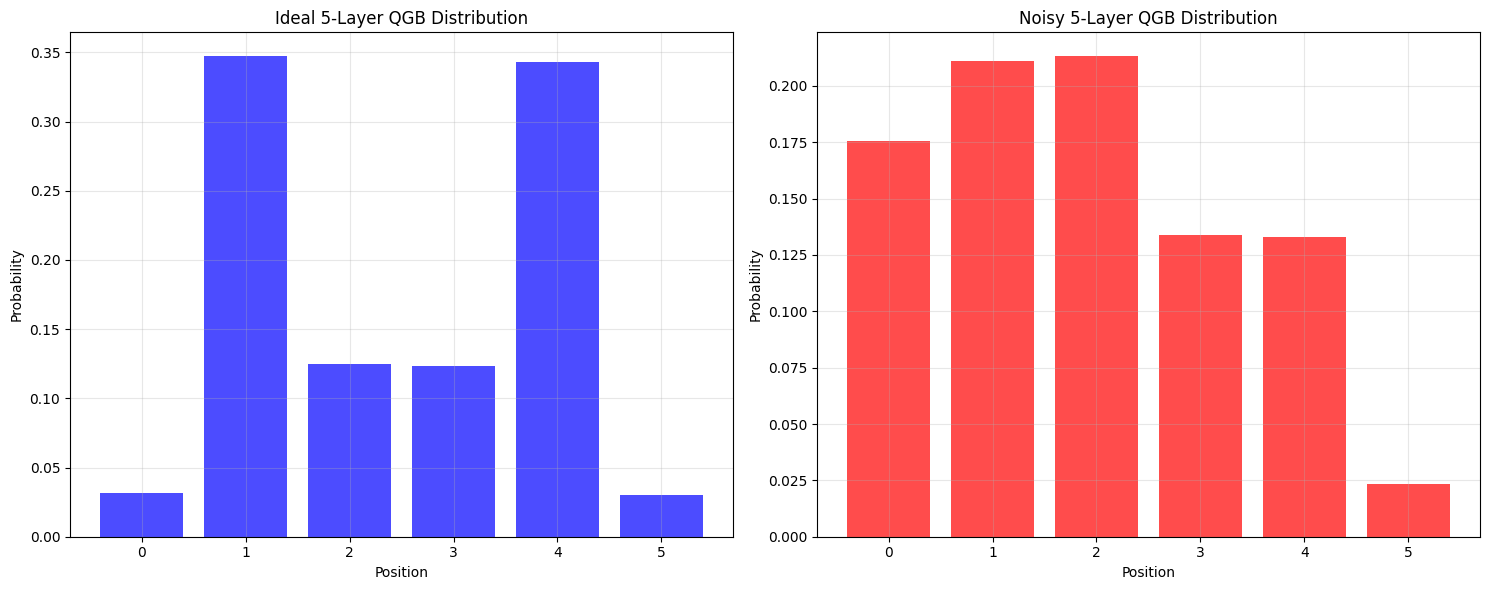


--- Noise Model Information ---
Device used: manhattan
Noise model type: <class 'qiskit_aer.noise.noise_model.NoiseModel'>
Number of noise instructions: 6

--- Difference Analysis ---
Position 0: Ideal=0.0312, Noisy=0.1754, Diff=0.1442
Position 1: Ideal=0.3472, Noisy=0.2112, Diff=0.1360
Position 2: Ideal=0.1246, Noisy=0.2131, Diff=0.0885
Position 3: Ideal=0.1237, Noisy=0.1337, Diff=0.0100
Position 4: Ideal=0.3434, Noisy=0.1331, Diff=0.2103
Position 5: Ideal=0.0299, Noisy=0.0233, Diff=0.0066

Total Variation Distance: 0.2978


In [ ]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit_aer.primitives import Sampler
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime.fake_provider import FakeManhattanV2, FakeTorino,FakeMarrakesh
from qiskit_aer.noise import NoiseModel
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from collections import defaultdict
import os

try:
    from IPython.display import display
    IS_IPYTHON = True
except ImportError:
    IS_IPYTHON = False

def create_n_layer_qgb(n_layers: int):
    """
    Generates a Qiskit Circuit for a Quantum Galton Board that performs
    a Hadamard Quantum Walk. This is achieved by using a bias angle of pi/2,
    which is equivalent to using a Hadamard gate as the "coin" at each step.

    Args:
        n_layers: The number of peg layers in the Galton board.

    Returns:
        A Qiskit QuantumCircuit object for the Hadamard Walk QGB.
    """
    num_working_qubits = 2 * n_layers + 1
    num_qubits = num_working_qubits + 1
    num_clbits = n_layers + 1

    qc = QuantumCircuit(num_qubits, num_clbits, name=f"{n_layers}-Layer Hadamard Walk")

    control_qubit = 0
    bias_angle = np.pi / 2  # This angle makes the Rx gate act like a Hadamard

    # --- Step 1: Initialization ---
    initial_ball_pos = n_layers + 1
    qc.x(initial_ball_pos)
    qc.rx(bias_angle, control_qubit)
    qc.barrier()

    # --- Step 2: Build the Layers ---
    for layer in range(n_layers):
        peg_positions = range(n_layers + 1 - layer, n_layers + 1 + layer + 1, 2)

        for i, peg_pos in enumerate(peg_positions):
            left_channel = peg_pos - 1
            right_channel = peg_pos + 1

            qc.cswap(control_qubit, left_channel, peg_pos)
            qc.cx(peg_pos, control_qubit)
            qc.cswap(control_qubit, peg_pos, right_channel)

            if i < len(peg_positions) - 1:
                qc.cx(right_channel, control_qubit)

        qc.barrier()

        if layer < n_layers - 1:
            # qc.reset(control_qubit)
            # qc.rx(bias_angle, control_qubit)
            qc.h(control_qubit)
            qc.barrier()

    # --- Step 3: Measurement ---
    output_qubits = range(1, num_working_qubits + 2, 2)
    qc.measure(output_qubits, range(num_clbits))

    return qc


def get_available_devices():
    """
    List available fake backend devices
    """
    devices = {
        'manhattan': FakeManhattanV2,
        'torino': FakeTorino,
        'marrakesh':FakeMarrakesh
    }
    return devices

def run_noisy_simulation(circuit, shots=8192, device_name='marrakesh'):
    """
    Run the circuit with device noise model simulation
    """
    # Get available devices
    devices = get_available_devices()

    # Create fake device backend
    if device_name.lower() in devices:
        fake_device = devices[device_name.lower()]()
    else:
        print(f"Unknown device '{device_name}'. Available devices: {list(devices.keys())}")
        print("Using default: FakeManhattan")
        fake_device = FakeManhattan()

    print(f"Using device: {fake_device.name}")
    print(f"Circuit requires {circuit.num_qubits} qubits, device has {fake_device.num_qubits} qubits")

    # Check if circuit fits on device
    if circuit.num_qubits > fake_device.num_qubits:
        print(f"WARNING: Circuit needs {circuit.num_qubits} qubits but device only has {fake_device.num_qubits}")
        print("Falling back to noise-model-only simulation (no coupling map constraints)")

        # Create noise model from the fake device
        noise_model = NoiseModel.from_backend(fake_device)

        # Create AerSimulator with noise model
        sim_noisy = AerSimulator(noise_model=noise_model)

        # Transpile with basic optimization only
        transpiled_circuit = transpile(circuit, sim_noisy, optimization_level=0)

    else:
        # Create noise model from the fake device
        noise_model = NoiseModel.from_backend(fake_device)

        # Get device properties
        coupling_map = fake_device.coupling_map
        basis_gates = fake_device.basis_gates

        # Create AerSimulator with noise model
        sim_noisy = AerSimulator(
            noise_model=noise_model,
            coupling_map=coupling_map,
            basis_gates=basis_gates
        )

        # Transpile circuit for the noisy backend with higher optimization
        try:
            transpiled_circuit = transpile(circuit, sim_noisy, optimization_level=3)
        except Exception as e:
            print(f"High optimization failed: {e}")
            print("Trying with coupling map disabled...")
            sim_noisy = AerSimulator(noise_model=noise_model)
            transpiled_circuit = transpile(circuit, sim_noisy, optimization_level=1)

    print(f"Original circuit depth: {circuit.depth()}")
    print(f"Transpiled circuit depth: {transpiled_circuit.depth()}")
    print(f"Number of qubits on device: {fake_device.num_qubits}")

    # Run the noisy simulation
    job = sim_noisy.run(transpiled_circuit, shots=shots)
    result = job.result()
    counts = result.get_counts(0)

    return counts, noise_model, transpiled_circuit

def compare_ideal_vs_noisy(circuit, n_layers, shots=8192, device_name='marrakesh'):
    """
    Compare ideal simulation vs noisy simulation results
    """
    print("=== IDEAL SIMULATION ===")

    # Use the original Sampler (V1) for compatibility
    sampler = Sampler()
    job = sampler.run(circuit, shots=shots)
    result = job.result()

    # Get counts from the result
    counts_data = result.quasi_dists[0]

    # Convert quasi-distribution to counts and then to probabilities
    ideal_distribution = defaultdict(float, {i: 0.0 for i in range(n_layers + 1)})

    for outcome, probability in counts_data.items():
        # Convert integer outcome to binary string
        bitstring = format(outcome, f'0{n_layers + 1}b')
        try:
            position = bitstring.index('1')
            ideal_distribution[position] += probability
        except ValueError:
            pass

    print("Ideal Results (Probabilities):")
    print({k: v for k, v in sorted(ideal_distribution.items())})

    print("\n=== NOISY SIMULATION ===")
    # Run noisy simulation
    noisy_counts, noise_model, transpiled_circuit = run_noisy_simulation(circuit, shots, device_name)

    # Convert counts to probabilities
    total_shots = sum(noisy_counts.values())
    noisy_distribution = defaultdict(float, {i: 0.0 for i in range(n_layers + 1)})

    for bitstring, count in noisy_counts.items():
        prob = count / total_shots
        try:
            position = bitstring.index('1')
            noisy_distribution[position] += prob
        except ValueError:
            pass

    print("Noisy Results (Probabilities):")
    print({k: v for k, v in sorted(noisy_distribution.items())})

    # Plot comparison
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Ideal histogram
    positions = list(ideal_distribution.keys())
    probabilities = list(ideal_distribution.values())
    ax1.bar(positions, probabilities, alpha=0.7, color='blue')
    ax1.set_title(f'Ideal {n_layers}-Layer QGB Distribution')
    ax1.set_xlabel('Position')
    ax1.set_ylabel('Probability')
    ax1.grid(True, alpha=0.3)

    # Noisy histogram
    positions_noisy = list(noisy_distribution.keys())
    probabilities_noisy = list(noisy_distribution.values())
    ax2.bar(positions_noisy, probabilities_noisy, alpha=0.7, color='red')
    ax2.set_title(f'Noisy {n_layers}-Layer QGB Distribution')
    ax2.set_xlabel('Position')
    ax2.set_ylabel('Probability')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()

    if IS_IPYTHON:
        display(fig)
    else:
        plt.show()

    return ideal_distribution, noisy_distribution, noise_model

# --- Example Usage ---
if __name__ == '__main__':
    N_LAYERS = 5

    qgb_circuit = create_n_layer_qgb(N_LAYERS)

    print(f"\n--- Circuit Information for {N_LAYERS}-Layer QGB ---")
    print(f"Circuit depth: {qgb_circuit.depth()}")
    print(f"Number of qubits: {qgb_circuit.num_qubits}")
    print(f"Number of classical bits: {qgb_circuit.num_clbits}")

    # Print available devices
    devices = get_available_devices()
    print(f"\nAvailable devices: {list(devices.keys())}")

    print("\nCircuit diagram:")
    print(qgb_circuit.draw(fold=120))

    print(f"\n--- Comparing Ideal vs Noisy Simulation for {N_LAYERS}-Layer QGB ---")

    # Test device name
    TEST_DEVICE = 'marrakesh'

    # Compare ideal and noisy results
    ideal_dist, noisy_dist, noise_model = compare_ideal_vs_noisy(qgb_circuit, N_LAYERS, shots=8192, device_name=TEST_DEVICE)

    # --- Noise Model Information ---
    print(f"\n--- Noise Model Information ---")
    print(f"Device used: {TEST_DEVICE}")
    print(f"Noise model type: {type(noise_model)}")
    print(f"Number of noise instructions: {len(noise_model._noise_instructions) if hasattr(noise_model, '_noise_instructions') else 'N/A'}")

    # Calculate and display the difference between ideal and noisy
    print(f"\n--- Difference Analysis ---")
    total_variation_distance = 0
    for position in range(N_LAYERS + 1):
        ideal_prob = ideal_dist.get(position, 0.0)
        noisy_prob = noisy_dist.get(position, 0.0)
        difference = abs(ideal_prob - noisy_prob)
        total_variation_distance += difference
        print(f"Position {position}: Ideal={ideal_prob:.4f}, Noisy={noisy_prob:.4f}, Diff={difference:.4f}")

    print(f"\nTotal Variation Distance: {total_variation_distance/2:.4f}")

    plt.close('all')